Test Exercise 6

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.fft import fft2, fftshift, ifft2, ifftshift
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import sys

import torch
import torch.nn as nn
import torch.optim as optim
# local imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# local imports
from Fast_MRI_dataloader import create_dataloaders
from week_3_ex5 import CNN_ex5

In [2]:
# set torches random seed
torch.random.manual_seed(0)
def get_k_space(MRI_image) :
    # convert MRI image into k-space
    #k_space = fftshift(fft2(MRI_image))
    k_space = fft2(MRI_image)
    return k_space

def get_partial_k_space(k_space,M) :
    # element wise multiplication of k-space and M
    return  torch.mul(k_space, M)

def get_accelerate_MRI(k_space) :
    # convert k-space to MRI image
    return ifft2(k_space)

def get_accelerate_MRI_final(input) :
    # convert k-space to MRI image
    return ifft2(ifftshift(input))


In [24]:
class ProxNet(nn.Module):
    def __init__(self, n_unfolded_iter, mu_init):
        super(ProxNet, self).__init__()

        self.n_unfolded_iter = n_unfolded_iter
        self.mu = nn.Parameter(torch.full((n_unfolded_iter,), mu_init))

        # module lists for the unfolded iterations
        self.proximal_operator = nn.ModuleList([CNN_ex5() for _ in range(self.n_unfolded_iter)])
    
    def forward(self, y, M):

        # initialize 
        x_t = y
        # iterate over the unfolded iterations
        for i in range(self.n_unfolded_iter):

            F_x = get_k_space(x_t)
            k_space_y = get_k_space(y)

            z = F_x - self.mu[i] * get_partial_k_space(F_x, M) + self.mu[i] * k_space_y
            
            # if i == self.n_unfolded_iter:
            #     x_t = get_accelerate_MRI_final(z)
            # else:
            x_t = get_accelerate_MRI(z)

            x_t = torch.abs(x_t)
            x_t = self.proximal_operator[i](x_t)

        #print("mu: ", self.mu.data)
       
        return x_t


In [28]:
def main():
    # define parameters
    data_loc = 'Fast_MRI_Knee/' #change the datalocation to something that works for you
    batch_size = 2

    # get the dataloaders
    train_loader, test_loader = create_dataloaders(data_loc, batch_size)

    model = ProxNet(n_unfolded_iter=5, mu_init=2.0)
    #print(model)

    # train the model
    device = torch.device('cuda:0')
    n_epochs = 10
    learning_rate = 1e-4
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # only take 1 batch of data to test
    for i,(partial_kspace, M, gt) in enumerate(tqdm(test_loader)):
        if i == 1:
            break
    # train the model
  
    # go over all epochs
    for epoch in range(n_epochs):
        print(f"\nTraining Epoch {epoch}:")
        
        train_loss = 0
      
        # unsqueeze to add channel dimension, (N, 320, 320) -> (N, 1, 320, 320)
        gt_unsqueeze = torch.unsqueeze(gt,dim =1)
        partial_kspace_unsqueeze = torch.unsqueeze(partial_kspace,dim =1)
        M_unsqueeze = torch.unsqueeze(M,dim =1)

        # get accelerated MRI image from partial k-space
        acc_mri = ifft2(partial_kspace_unsqueeze)
    
        #acc_mri = torch.abs(acc_mri)

        # move to device
        gt_unsqueeze = gt_unsqueeze.to(device)
        acc_mri = acc_mri.to(device)
        model = model.to(device)
        M_unsqueeze = M_unsqueeze.to(device)

        # forward pass
        x_out = model(acc_mri,M_unsqueeze)
        loss = criterion(x_out, gt_unsqueeze) 
    
        # backward pass, update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # add loss to the total loss
        train_loss += loss.item()

        print(f"Average train loss for epoch {epoch} is {train_loss}")

    return x_out, gt_unsqueeze


In [29]:
x_out, gt_unsqueeze = main()


  1%|          | 1/123 [00:00<00:09, 13.37it/s]



Training Epoch 0:
Average train loss for epoch 0 is 0.10241933912038803

Training Epoch 1:
Average train loss for epoch 1 is 0.05228741839528084

Training Epoch 2:
Average train loss for epoch 2 is 0.04603760689496994

Training Epoch 3:
Average train loss for epoch 3 is 0.044128015637397766

Training Epoch 4:
Average train loss for epoch 4 is 0.04323441907763481

Training Epoch 5:
Average train loss for epoch 5 is 0.04264940321445465

Training Epoch 6:
Average train loss for epoch 6 is 0.04216822609305382

Training Epoch 7:
Average train loss for epoch 7 is 0.04173823446035385

Training Epoch 8:
Average train loss for epoch 8 is 0.04135734587907791

Training Epoch 9:
Average train loss for epoch 9 is 0.041028942912817


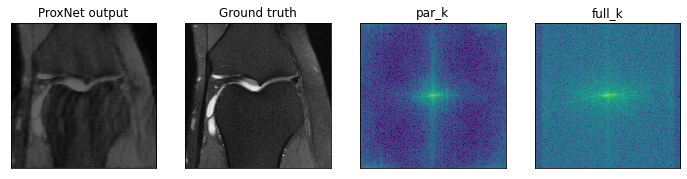

In [32]:
# detach x_out from GPU
x_out_plot = x_out.detach().cpu().numpy()
gt_unsqueeze_plot = gt_unsqueeze.detach().cpu().numpy()
par_k = fftshift(fft2(x_out.detach().cpu()))
full_k = fftshift(fft2(gt_unsqueeze.detach().cpu()))
par_k_plot_friendly = torch.log(torch.abs(par_k[0,0,:,:])+1e-20)
full_k_plot_friendly = torch.log(torch.abs(full_k[0,0,:,:])+1e-20)

plt.figure(figsize = (12,12))
    
plt.subplot(1,4,1)
plt.imshow(x_out_plot[0,0,:,:],vmax=2.3, interpolation='nearest',cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('ProxNet output')

plt.subplot(1,4,2)
plt.imshow(gt_unsqueeze_plot[0,0,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Ground truth')

plt.subplot(1,4,3)
plt.imshow(par_k_plot_friendly,vmin=-2.3, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('par_k')

plt.subplot(1,4,4)
plt.imshow(full_k_plot_friendly,vmin=-2.3, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('full_k')

#plt.savefig(f"{save_path}", dpi=300, bbox_inches='tight')
plt.show()